# Car Market Analysis
### Objective
Analysis current car market data for Toyota RAV4 and Honda CR-V and Pilot models.

### Cleaning the Data

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import re

In [7]:
# Column names for csv files
cols_name = ['car_url', 'year_make_model', 'price_col', 'details_short', 'details_long' ]
 
# load all datasets
honda_crv_df = pd.read_csv("/home/lfigil/Documents/car_scraper/car_dataset_original/honda_data.csv", names=cols_name)
honda_pilot_df = pd.read_csv("/home/lfigil/Documents/car_scraper/car_dataset_original/honda_pilot.csv", names=cols_name)

In [11]:
# Quick view of the dfs shape
print(honda_crv_df.shape)
print(honda_pilot_df.shape)

(2612, 5)
(707, 5)


In [48]:
honda_crv_df.head(5)

,car_url,year_make_model,price_col,details_short,details_long
0,https://www.edmunds.com/honda/cr-v/2019/vin/5J...,2019 Honda CR-V\nLX 4dr SUV,"$15,000\ngreat price\n$4,956 below market","65,977 miles\nNo accidents, 2 Owners, Personal...","['Located in Elizabeth, NJ / 19 miles away fro..."
1,https://www.edmunds.com/honda/cr-v/2020/vin/5J...,2020 Honda CR-V\nLX 4dr SUV,"$17,000\ngreat price\n$4,757 below market","42,476 miles\nNo accidents, 3 Owners, Rental v...","['Located in Elizabeth, NJ / 19 miles away fro..."
2,https://www.edmunds.com/honda/cr-v/2019/vin/2H...,2019 Honda CR-V\nLX 4dr SUV,"$14,900\ngreat price\n$4,251 below market","80,621 miles\nNo accidents, 2 Owners, Personal...","['Located in Elizabeth, NJ / 19 miles away fro..."
3,https://www.edmunds.com/honda/cr-v/2021/vin/5J...,Certified 2021 Honda CR-V\nEX-L 4dr SUV,"$25,949\ngreat price\n$3,020 below market","17,096 miles\nNo accidents, 1 Owner, Personal ...","['Located in Jersey City, NJ / 12 miles away f..."
4,https://www.edmunds.com/honda/cr-v/2023/vin/7F...,2023 Honda CR-V\nSport Touring Hybrid 4dr SUV,"$31,685\ngreat price\n$6,409 below market","6,309 miles\nNo accidents, 1 Owner, Personal u...","['Located in Valley Stream, NY / 23 miles away..."


In [19]:
col1_tmp = honda_crv_df['year_make_model'].str.replace("\n", " ").str.strip().str.split(" ", expand=True)
col1_tmp = col1_tmp.rename(columns={0: 'Year', 1: 'Make', 2: 'Model', 3: 'Trim', 4: 'Doors', 5: 'type'})
col1_tmp = col1_tmp[col1_tmp['Year'] == 'Certified'].shift(-1, axis=1)

In [64]:
# Separate the `year_make_model` column by the newline which results in two new columns
tmp_cols_1 = honda_crv_df['year_make_model'].str.split("\n", expand=True)

# Replace rows with the word 'Certified' with and empty string
tmp_cols_1[0] = tmp_cols_1[0].str.replace('Certified', '').str.strip()

In [66]:
# Split into year, make, model columns to original df
honda_crv_df[['Year', 'Make', 'Model']] = tmp_cols_1[0] .str.split(" ", expand=True)

In [9]:
def extract_trim_info(text):
    pattern = r'^(.*?)\s+(\d+dr\s\S+)(.*)$'
    
    match = re.match(pattern, text)
    if match:
        trim = match.group(1).strip()  # Trim level
        doors_type = match.group(2).strip()  # Number of doors and car type
        
        # Extract number of doors and car type
        # Use a separate pattern to extract the number of doors and type from the captured doors_type string
        doors_pattern = r'(\d+dr)\s(\S+)'
        doors_match = re.match(doors_pattern, doors_type)
        if doors_match:
            doors = doors_match.group(1).strip()
            car_type = doors_match.group(2).strip()
        else:
            doors = None
            car_type = None
        
        return trim, doors, car_type
    else:
        # If no match, return None or empty strings
        return None, None, None

In [89]:
honda_crv_df['Trim'], honda_crv_df['Doors'], honda_crv_df['Type'] = zip(*tmp_cols_1[1].apply(extract_trim_info))

In [10]:
# Extract the dollar value from the price_col column and convert into numeric form
def extract_price(text):
    pattern = r'\$?(\d{1,3}(?:,\d{3})*(?:\.\d+)?)'
    
    match = re.search(pattern, text)
    if match:
        # Extracted number is the first numeric value found in the text
        numeric_value = match.group(1)
        
        # Remove commas and convert to float for further use
        numeric_value = numeric_value.replace(',', '')
        return float(numeric_value)
    else:
        # If no numeric value is found, return None
        return None

In [ ]:
honda_crv_df['price'] = honda_crv_df['price_col'].apply(extract_price)

In [123]:
# Separate the details_short column into new columns by new line for further information extraction
tmp_3 = honda_crv_df['details_short'].str.split("\n", expand=True)

# This new columns will need further cleaning
tmp_3 = tmp_3.rename(columns={0: 'mileage', 1: 'details1'})

In [15]:
def extract_miles(text):
    pattern = r'(\d{1,3}(?:,\d{3})*)\s+miles$'

    match = re.search(pattern, text)

    if match:
        miles = match.group(1).replace(',', '')
        return int(miles)
    else:
        return None

In [ ]:
honda_crv_df['Mileage'] = tmp_3['mileage'].apply(extract_miles)

In [ ]:
tmp_4 = tmp_3['details1'].str.split(", ",expand=True)
tmp_4[['Owners', 'del', 'del2']] = tmp_4[1].str.split(" ", expand=True)
tmp_4[['Accidents', 'del3', 'del4']] = tmp_4[0].str.split(" ", expand=True)
tmp_4['Accidents'] = tmp_4['Accidents'].replace("No", "0")
tmp_4 = tmp_4.rename(columns={2: "Usage"})
honda_crv_df[['Accidents', 'Owners', 'Usage']] = tmp_4[['Accidents', 'n', 'Usage']]

In [154]:
pd.set_option('display.max_columns', None)

In [158]:
tmp_details_long = honda_crv_df['details_long'].str.split(",", expand=True)
# Define the key phrases you want to extract
keys_to_extract = {
    'Title Details': 'Title Details:',
    'Salvage Vehicle': 'Salvage Vehicle:',
    'Frame Damage': 'Frame Damage:',
    'Theft History': 'Theft History:',
    'Lemon Status': 'Lemon Status:',
    'Certified Pre-Owned': 'Certified Pre-Owned:',
    'Listed since': 'Listed since'
}

# Initialize empty columns for the keys
for key in keys_to_extract:
    honda_crv_df[key] = None

# Function to extract values based on the specified keys
def extract_information(details_list, keys):
    # Create a dictionary to hold the extracted values
    extracted_info = {}
    
    # Iterate through each string in the list
    for detail in details_list:
        # Check each key to see if it is present in the current detail string
        for key, prefix in keys.items():
            if prefix in detail:
                # Extract the value after the key prefix
                value = detail.split(prefix)[1].strip()
                # Store the value in the dictionary
                extracted_info[key] = value
    
    return extracted_info

# Iterate through each row in the DataFrame
for index, row in honda_crv_df.iterrows():
    # Parse the list of strings from the 'details_long' column
    details_list = eval(row['details_long'])  # Convert string representation of list to actual list
    
    # Extract the information using the function
    extracted_info = extract_information(details_list, keys_to_extract)
    
    # Assign the extracted information to the appropriate columns
    for key, value in extracted_info.items():
        honda_crv_df.loc[index, key] = value

honda_crv_df['Certified Pre-Owned'] = honda_crv_df['Certified Pre-Owned'].str.split("\n")[0]
honda_crv_df['Certified Pre-Owned'] = honda_crv_df['Certified Pre-Owned'].str.split("\n",expand=True)[0]
honda_crv_df['Listed since'] = pd.to_datetime(honda_crv_df['Listed since'].str.replace(": ", "").str.strip())

In [184]:
# Get only the clean data into new df
honda_crv_clean = honda_crv_df[['Year', 'Make', 'Model', 'Trim', 'Doors', 'Type', 'price', 'Mileage', 
                                'Accidents', 'Owners', 'Usage', 'Title Details', 'Salvage Vehicle', 
                                'Frame Damage', 'Theft History', 'Lemon Status', 'Certified Pre-Owned', 
                                'Listed since', 'car_url']]

save_path = "/home/lfigil/Documents/car_scraper/car_dataset_original/honda_crv_clean.csv"

honda_crv_clean.to_csv(save_path, index=False)

print(f"file save at {save_path}...")

file save at /home/lfigil/Documents/car_scraper/car_dataset_original/honda_crv_clean.csv...


In [183]:
honda_crv_df.columns

Index(['car_url', 'year_make_model', 'price_col', 'details_short',
       'details_long', 'Year', 'Make', 'Model', 'Trim', 'Doors', 'Type',
       'price', 'mileage', 'Mileage', 'Accidents', 'Owners', 'Usage',
       'Title Details', 'Salvage Vehicle', 'Frame Damage', 'Theft History',
       'Lemon Status', 'VIN', 'Stock', 'Certified Pre-Owned', 'Listed since'],
      dtype='object')

Now, it's time to clean the honda pilot data

In [3]:
# Column names for csv files
cols_name = ['car_url', 'year_make_model', 'price_col', 'details_short', 'details_long' ]
 
# load all datasets
honda_pilot_df = pd.read_csv("/home/lfigil/Documents/car_scraper/car_dataset_original/honda_pilot.csv", names=cols_name)

In [13]:
# Split tje year_make_model
temp_1 = honda_pilot_df['year_make_model'].str.split("\n", expand=True)


In [17]:
honda_pilot_df['Trim'], honda_pilot_df['Doors'], honda_pilot_df['Type'] = zip(*temp_1[1].apply(extract_trim_info))

In [19]:
# Replace rows with the word 'Certified' with and empty string
temp_1[0] = temp_1[0].str.replace('Certified', '').str.strip()

# Split into year, make, model columns to original df
honda_pilot_df[['Year', 'Make', 'Model']] = temp_1[0] .str.split(" ", expand=True)

In [22]:
honda_pilot_df['Price'] = honda_pilot_df['price_col'].apply(extract_price)

In [25]:
# Separate the details_short column into new columns by new line for further information extraction
temp_2 = honda_pilot_df['details_short'].str.split("\n", expand=True)

# This new columns will need further cleaning
temp_2 = temp_2.rename(columns={0: 'mileage', 1: 'details1'})

In [27]:
honda_pilot_df['Mileage'] = temp_2['mileage'].apply(extract_miles)

In [28]:
temp_2

,mileage,details1,2,3,4
0,"57,108 miles","No accidents, 1 Owner, Personal use",6cyl Automatic,M Sport Motor Cars (16 mi away),Home delivery*
1,"65,589 miles","4 Accidents, 2 Owners, Personal use only",6cyl Automatic,Lynnes Nissan City (10 mi away),Five Star Dealer
2,"59,065 miles","No accidents, 2 Owners, Rental vehicle",6cyl Automatic,Auto Lux (23 mi away),None
3,"59,291 miles","No accidents, 1 Owner, Personal use only",6cyl Automatic,North Shore Honda (23 mi away),Home delivery*
4,"41,423 miles","2 Accidents, 1 Owner, Personal use",6cyl Automatic,Hudson Honda (7 mi away),Home delivery*
...,...,...,...,...,...
702,"65,258 miles","2 Accidents, 1 Owner, Personal use only",6cyl Automatic,Millennium Honda (25 mi away),None
703,"43,976 miles","1 Accident, 3 Owners, Personal use",6cyl Automatic,Drive Deleon (11 mi away),None
704,"51,664 miles","2 Accidents, 2 Owners, Personal use",6cyl Automatic,Drive Deleon (11 mi away),None
705,"67,223 miles","1 Accident, 1 Owner, Personal use",6cyl Automatic,Straight Motor Sales (6 mi away),None


In [47]:
temp_3 = temp_2['details1'].str.split(", ",expand=True)
temp_3[['Owners', 'del', 'del2']] = temp_3[1].str.split(" ", expand=True)
temp_3[['Accidents', 'del3', 'del4']] = temp_3[0].str.split(" ", expand=True)
temp_3['Accidents'] = temp_3['Accidents'].replace("No", "0")
temp_3 = temp_3.rename(columns={2: "Usage"})


In [49]:
honda_pilot_df[['Accidents', 'Owners', 'Usage']] = temp_3[['Accidents', 'Owners', 'Usage']]

In [13]:
# Function to extract values based on the specified keys
def extract_information(details_list, keys):
    # Create a dictionary to hold the extracted values
    extracted_info = {}
    
    # Iterate through each string in the list
    for detail in details_list:
        # Check each key to see if it is present in the current detail string
        for key, prefix in keys.items():
            if prefix in detail:
                # Extract the value after the key prefix
                value = detail.split(prefix)[1].strip()
                # Store the value in the dictionary
                extracted_info[key] = value
    
    return extracted_info

In [54]:
tmp_details_long = honda_pilot_df['details_long'].str.split(",", expand=True)

# Define the key phrases you want to extract
keys_to_extract = {
    'Title Details': 'Title Details:',
    'Salvage Vehicle': 'Salvage Vehicle:',
    'Frame Damage': 'Frame Damage:',
    'Theft History': 'Theft History:',
    'Lemon Status': 'Lemon Status:',
    'Certified Pre-Owned': 'Certified Pre-Owned:',
    'Listed since': 'Listed since'
}

# Initialize empty columns for the keys
for key in keys_to_extract:
    honda_pilot_df[key] = None

# Iterate through each row in the DataFrame
for index, row in honda_pilot_df.iterrows():
    # Parse the list of strings from the 'details_long' column
    details_list = eval(row['details_long'])  # Convert string representation of list to actual list
    
    # Extract the information using the function
    extracted_info = extract_information(details_list, keys_to_extract)
    
    # Assign the extracted information to the appropriate columns
    for key, value in extracted_info.items():
        honda_pilot_df.loc[index, key] = value

In [61]:
honda_pilot_df['Certified Pre-Owned'] = honda_pilot_df['Certified Pre-Owned'].str.split("\n",expand=True)[0]
honda_pilot_df['Listed since'] = pd.to_datetime(honda_pilot_df['Listed since'].str.replace(": ", "").str.strip())

In [63]:
honda_pilot_df.columns

Index(['car_url', 'year_make_model', 'price_col', 'details_short',
       'details_long', 'Trim', 'Doors', 'Type', 'Year', 'Make', 'Model',
       'Price', 'Mileage', 'Accidents', 'Owners', 'Usage', 'Title Details',
       'Salvage Vehicle', 'Frame Damage', 'Theft History', 'Lemon Status',
       'Certified Pre-Owned', 'Listed since'],
      dtype='object')

In [64]:
honda_pilot_clean = honda_pilot_df[['Year', 'Make', 'Model', 'Trim', 'Doors', 'Type', 'Price', 'Mileage', 'Accidents', 
                                    'Owners', 'Usage', 'Title Details', 'Salvage Vehicle', 'Frame Damage', 'Theft History', 
                                    'Lemon Status', 'Certified Pre-Owned', 'Listed since', 'car_url']]

In [66]:
save_path = "/home/lfigil/Documents/car_scraper/car_dataset_original/honda_pilot_clean.csv"

honda_pilot_clean.to_csv(save_path, index=False)

print(f"file save at {save_path} !!!")

file save at /home/lfigil/Documents/car_scraper/car_dataset_original/honda_pilot_clean.csv !!!


In [6]:
# Column names
cols = ['car_url', 'year_make_model', 'price', 'details_short', 'details_long' ]

toyota_df = pd.read_csv('/home/lfigil/Documents/car_scraper/car_dataset_original/toyota_data.csv', names=cols)

In [25]:
col1_tmp = toyota_df['year_make_model'].str.replace("\n", " ").str.strip().str.split(" ", expand=True)
col1_tmp = col1_tmp.rename(columns={0: 'Year', 1: 'Make', 2: 'Model', 3: 'Trim', 4: 'Doors', 5: 'type'})
col1_tmp = col1_tmp[col1_tmp['Year'] == 'Certified'].shift(-1, axis=1)

In [26]:
# Separate the `year_make_model` column by the newline which results in two new columns
tmp_cols_1 = toyota_df['year_make_model'].str.split("\n", expand=True)

# Replace rows with the word 'Certified' with and empty string
tmp_cols_1[0] = tmp_cols_1[0].str.replace('Certified', '').str.strip()

In [28]:
# Split into year, make, model columns to original df
toyota_df[['Year', 'Make', 'Model']] = tmp_cols_1[0] .str.split(" ", expand=True)

In [36]:
toyota_df[['Trim', 'Doors', 'Type', 'x']] = tmp_cols_1[1].str.split(" ", expand=True)

In [38]:
toyota_df['price'] = toyota_df['price'].apply(extract_price)

In [39]:
# Separate the details_short column into new columns by new line for further information extraction
tmp_3 = toyota_df['details_short'].str.split("\n", expand=True)

# This new columns will need further cleaning
tmp_3 = tmp_3.rename(columns={0: 'mileage', 1: 'details1'})

In [40]:
toyota_df['Mileage'] = tmp_3['mileage'].apply(extract_miles)

In [42]:
tmp_4 = tmp_3['details1'].str.split(", ",expand=True)
tmp_4[['Owners', 'del', 'del2']] = tmp_4[1].str.split(" ", expand=True)
tmp_4[['Accidents', 'del3', 'del4']] = tmp_4[0].str.split(" ", expand=True)
tmp_4['Accidents'] = tmp_4['Accidents'].replace("No", "0")
tmp_4 = tmp_4.rename(columns={2: "Usage"})
toyota_df[['Accidents', 'Owners', 'Usage']] = tmp_4[['Accidents', 'Owners', 'Usage']]

In [45]:
tmp_details_long = toyota_df['details_long'].str.split(",", expand=True)
# Define the key phrases you want to extract
keys_to_extract = {
    'Title Details': 'Title Details:',
    'Salvage Vehicle': 'Salvage Vehicle:',
    'Frame Damage': 'Frame Damage:',
    'Theft History': 'Theft History:',
    'Lemon Status': 'Lemon Status:',
    'Certified Pre-Owned': 'Certified Pre-Owned:',
    'Listed since': 'Listed since'
}

# Initialize empty columns for the keys
for key in keys_to_extract:
    toyota_df[key] = None

# Function to extract values based on the specified keys
def extract_information(details_list, keys):
    # Create a dictionary to hold the extracted values
    extracted_info = {}
    
    # Iterate through each string in the list
    for detail in details_list:
        # Check each key to see if it is present in the current detail string
        for key, prefix in keys.items():
            if prefix in detail:
                # Extract the value after the key prefix
                value = detail.split(prefix)[1].strip()
                # Store the value in the dictionary
                extracted_info[key] = value
    
    return extracted_info

# Iterate through each row in the DataFrame
for index, row in toyota_df.iterrows():
    # Parse the list of strings from the 'details_long' column
    details_list = eval(row['details_long'])  # Convert string representation of list to actual list
    
    # Extract the information using the function
    extracted_info = extract_information(details_list, keys_to_extract)
    
    # Assign the extracted information to the appropriate columns
    for key, value in extracted_info.items():
        toyota_df.loc[index, key] = value

toyota_df['Certified Pre-Owned'] = toyota_df['Certified Pre-Owned'].str.split("\n",expand=True)[0]
toyota_df['Listed since'] = pd.to_datetime(toyota_df['Listed since'].str.replace(": ", "").str.strip())

In [47]:
# Get only the clean data into new df
toyota_rav4_clean = toyota_df[['Year', 'Make', 'Model', 'Trim', 'Doors', 'Type', 'price', 'Mileage', 
                                'Accidents', 'Owners', 'Usage', 'Title Details', 'Salvage Vehicle', 
                                'Frame Damage', 'Theft History', 'Lemon Status', 'Certified Pre-Owned', 
                                'Listed since', 'car_url']]

save_path = "/home/lfigil/Documents/car_scraper/car_dataset_original/toyota_rav4_clean.csv"

toyota_rav4_clean.to_csv(save_path, index=False)

print(f"file save at {save_path}...")

file save at /home/lfigil/Documents/car_scraper/car_dataset_original/toyota_rav4_clean.csv...


# Check for data types

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read clean data
toyota_df = pd.read_csv("./car_dataset_original/toyota_rav4_clean.csv")
honda_p_df = pd.read_csv("./car_dataset_original/honda_pilot_clean.csv")
honda_c_df = pd.read_csv("./car_dataset_original/honda_crv_clean.csv")

In [4]:
toyota_df.drop(columns=['Doors', 'Type'], inplace=True)

In [5]:
toyota_df.isna().sum()

Year                      0
Make                      0
Model                     0
Trim                      1
price                    73
Mileage                   6
Accidents                 0
Owners                  142
Usage                   144
Title Details           142
Salvage Vehicle         142
Frame Damage            142
Theft History           142
Lemon Status            142
Certified Pre-Owned       0
Listed since           1095
car_url                   0
dtype: int64

In [6]:
toyota_df.shape

(2282, 17)

In [7]:
# Remove listing of cars older than 2019
toyota_df['Year'].value_counts()

Year
2021    772
2022    213
2020    208
2023    192
2018    190
2019    188
2017    108
2015     91
2016     80
2013     67
2014     58
2012     27
2011     26
2008     16
2024     12
2010     12
2009      6
2007      6
2004      4
2006      4
2001      1
1999      1
Name: count, dtype: int64

In [8]:
# Get the count of cars from 2019 and later
listings_count = toyota_df[toyota_df['Year'] >= 2019].reset_index(drop=True)

In [9]:
listings_count['Year'].describe()

count    1585.000000
mean     2021.030915
std         1.136928
min      2019.000000
25%      2021.000000
50%      2021.000000
75%      2022.000000
max      2024.000000
Name: Year, dtype: float64

The toyota listing originally contained 2,282 records in it. However, since we are only interested in new cars, I remove the cars that are older than 2019 giving a 1,585 car listings. About 30% of the listings were removed from the original dataset. Now, it is time to remove cars where the price and mileage are rows are missing.

In [10]:
listings_count.isna().sum()

Year                     0
Make                     0
Model                    0
Trim                     0
price                   56
Mileage                  5
Accidents                0
Owners                  88
Usage                   90
Title Details           88
Salvage Vehicle         88
Frame Damage            88
Theft History           88
Lemon Status            88
Certified Pre-Owned      0
Listed since           734
car_url                  0
dtype: int64

In [11]:
listings_count = listings_count.dropna(subset=['price'])
listings_count

,Year,Make,Model,Trim,price,Mileage,Accidents,Owners,Usage,Title Details,Salvage Vehicle,Frame Damage,Theft History,Lemon Status,Certified Pre-Owned,Listed since,car_url
0,2021,Toyota,RAV4,XLE,18879.0,59711.0,1,1,Rental vehicle,Clean Title,No,No,No,No,No,2024-01-24,https://www.edmunds.com/toyota/rav4/2021/vin/2...
1,2022,Toyota,RAV4,LE,20900.0,31372.0,1,2,Corporate fleet vehicle,Clean Title,No,No,No,No,No,2023-12-30,https://www.edmunds.com/toyota/rav4/2022/vin/2...
2,2021,Toyota,RAV4,XLE,16900.0,64709.0,1,3,Corporate fleet vehicle,Clean Title,No,No,No,No,No,2024-01-25,https://www.edmunds.com/toyota/rav4/2021/vin/2...
3,2020,Toyota,RAV4,LE,18980.0,91273.0,0,2,Rental vehicle,Clean Title,No,No,No,No,No,2024-02-21,https://www.edmunds.com/toyota/rav4/2020/vin/2...
4,2019,Toyota,RAV4,XLE,20000.0,73800.0,0,2,Personal use only,Clean Title,No,No,No,No,No,2024-01-25,https://www.edmunds.com/toyota/rav4/2019/vin/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1580,2021,Toyota,RAV4,XLE,29995.0,44589.0,1,1,Personal use,Clean Title,No,No,No,No,No,2024-03-26,https://www.edmunds.com/toyota/rav4/2021/vin/2...
1581,2021,Toyota,RAV4,LE,26858.0,48762.0,1,1,Personal use,Clean Title,No,No,No,No,No,2024-04-10,https://www.edmunds.com/toyota/rav4/2021/vin/2...
1582,2021,Toyota,RAV4,XLE,28995.0,61070.0,1,1,Personal use,Clean Title,No,No,No,No,No,2024-03-05,https://www.edmunds.com/toyota/rav4/2021/vin/2...
1583,2021,Toyota,RAV4,XLE,25698.0,65205.0,1,1,Personal use only,Clean Title,No,No,No,No,No,2024-04-04,https://www.edmunds.com/toyota/rav4/2021/vin/2...


In [12]:
listings_count = listings_count.dropna(subset=['Mileage'])
listings_count.reset_index(inplace=True, drop=True)

In [13]:
listings_count.isna().sum()

Year                     0
Make                     0
Model                    0
Trim                     0
price                    0
Mileage                  0
Accidents                0
Owners                  85
Usage                   86
Title Details           85
Salvage Vehicle         85
Frame Damage            85
Theft History           85
Lemon Status            85
Certified Pre-Owned      0
Listed since           733
car_url                  0
dtype: int64

Althought there are still missing values on some of the columns, I only will need the price, mileage, trim, and year to get a high level overview of the current car inventory and the price trend.

In [14]:
# Get a subset of the data with only the Year, Trim, price, Mileage.
toyota_rav4_subset = listings_count[['Year', 'Trim', 'price', 'Mileage']]
toyota_rav4_subset

,Year,Trim,price,Mileage
0,2021,XLE,18879.0,59711.0
1,2022,LE,20900.0,31372.0
2,2021,XLE,16900.0,64709.0
3,2020,LE,18980.0,91273.0
4,2019,XLE,20000.0,73800.0
...,...,...,...,...
1519,2021,XLE,29995.0,44589.0
1520,2021,LE,26858.0,48762.0
1521,2021,XLE,28995.0,61070.0
1522,2021,XLE,25698.0,65205.0


In [15]:
plt.rcParams['figure.figsize'] = [12, 6]

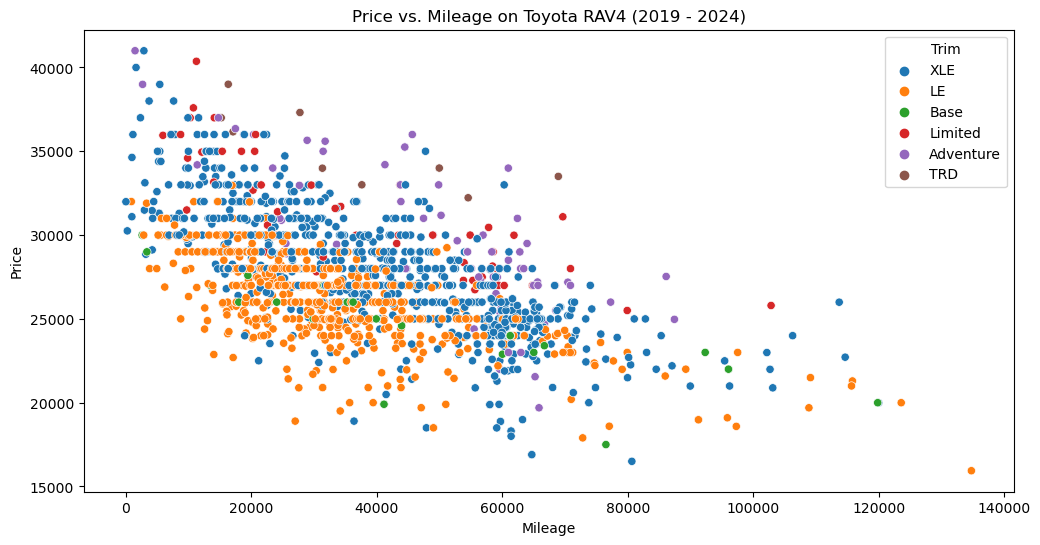

In [66]:
sns.scatterplot(x='Mileage', y='price', data=toyota_rav4_subset, hue='Trim')
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Price vs. Mileage on Toyota RAV4 (2019 - 2024)")

plt.savefig("tyt_rav4_scatterplot1.png")
plt.show()

/home/lfigil/anaconda3/envs/scrape/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


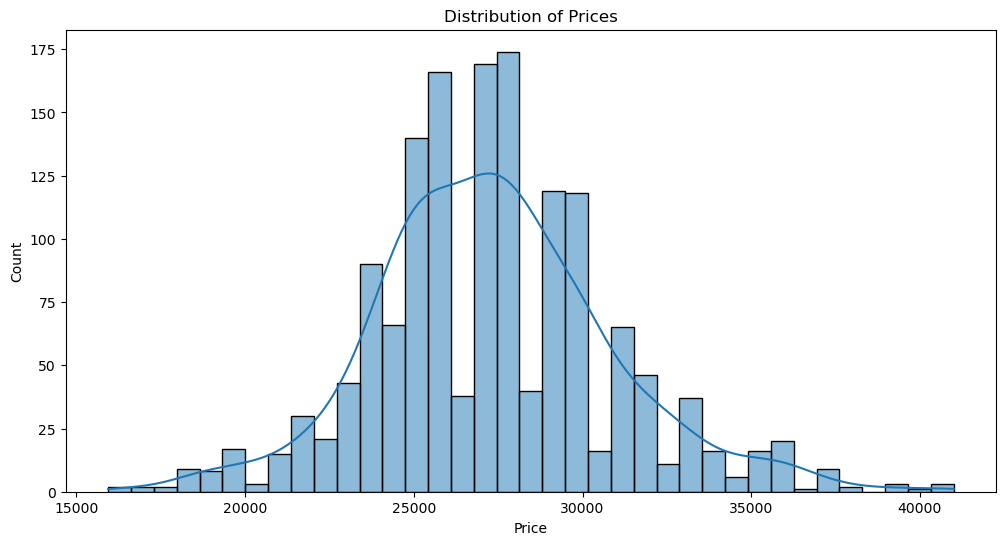

In [17]:
sns.histplot(toyota_rav4_subset['price'], kde=True)
plt.xlabel('Price')
plt.title('Distribution of Prices')
plt.show()

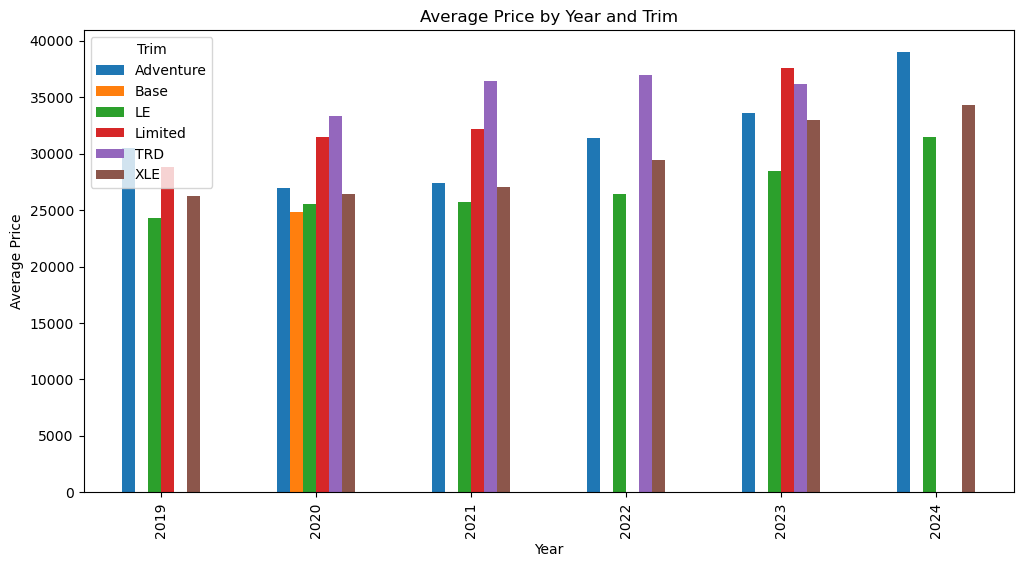

In [18]:
# Calculate average price by Year and Trim
avg_price = toyota_rav4_subset.groupby(['Year', 'Trim'])['price'].mean().unstack()

# Plot the average price
avg_price.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.title('Average Price by Year and Trim')
plt.show()

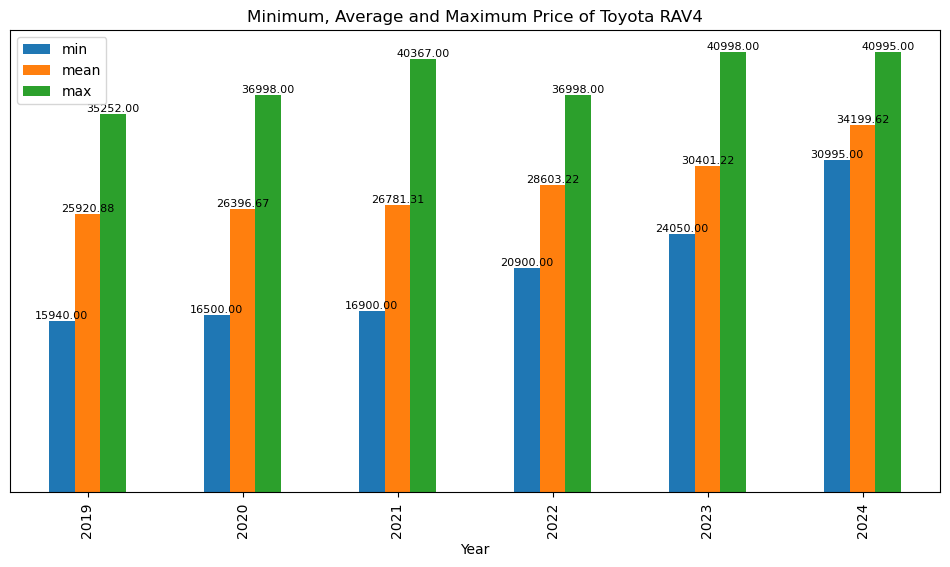

In [23]:
# Calculate average price by Year and Trim
x = toyota_rav4_subset.groupby(['Year'])['price'].aggregate(['min', 'mean', 'max'])

# Plot the average price
ax = x.plot(kind='bar')
plt.title('Minimum, Average and Maximum Price of Toyota RAV4')

# Add data labels to the bar chart
for container in ax.containers:
    # Add data labels to each bar in the container
    for bar in container:
        height = bar.get_height()
        # Format the label to show the price with two decimal places
        label = f'{height:.2f}'
        # Set the text label slightly above the bar
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            label,
            ha='center',  # horizontal alignment
            va='bottom',  # vertical alignment
            fontsize=8,   # set the font size as desired
        )

ax.set_yticks([])

plt.show()

Now that I have a high level overview of the RAV4 inventory price, I will do the same for the Honda CR-V and Pilot

In [28]:
honda_p_df.tail(5)

,Year,Make,Model,Trim,Doors,Type,Price,Mileage,Accidents,Owners,Usage,Title Details,Salvage Vehicle,Frame Damage,Theft History,Lemon Status,Certified Pre-Owned,Listed since,car_url
702,2021,Honda,Pilot,EX-L,4dr,SUV,NaN,65258.0,2,1,Personal use only,Clean Title,No,No,No,No,No,2024-02-22,https://www.edmunds.com/honda/pilot/2021/vin/5...
703,2019,Honda,Pilot,LX,4dr,SUV,32995.0,43976.0,1,3,Personal use,Clean Title,No,No,No,No,No,2022-10-11,https://www.edmunds.com/honda/pilot/2019/vin/5...
704,2019,Honda,Pilot,EX,4dr,SUV,34995.0,51664.0,2,2,Personal use,Clean Title,No,No,No,No,No,2022-06-15,https://www.edmunds.com/honda/pilot/2019/vin/5...
705,2021,Honda,Pilot,Elite,4dr,SUV,30991.0,67223.0,1,1,Personal use,Clean Title,No,No,No,No,No,2024-04-12,https://www.edmunds.com/honda/pilot/2021/vin/5...
706,2019,Honda,Pilot,EX,4dr,SUV,NaN,51306.0,6cyl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,2024-04-13,https://www.edmunds.com/honda/pilot/2019/vin/5...


In [29]:
honda_c_df.tail(5)

,Year,Make,Model,Trim,Doors,Type,price,Mileage,Accidents,Owners,Usage,Title Details,Salvage Vehicle,Frame Damage,Theft History,Lemon Status,Certified Pre-Owned,Listed since,car_url
2607,2018,Honda,CR-V,EX,4dr,SUV,NaN,72000.0,1,3,Personal use,Clean Title,No,No,No,No,No,2023-11-11,https://www.edmunds.com/honda/cr-v/2018/vin/2H...
2608,2021,Honda,CR-V,EX,4dr,SUV,NaN,36869.0,1,1,Personal use,Clean Title,No,No,No,No,No,2024-04-07,https://www.edmunds.com/honda/cr-v/2021/vin/2H...
2609,2017,Honda,CR-V,EX-L,4dr,SUV,16995.0,127357.0,1,2,Personal use only,Clean Title,No,No,No,No,No,2024-02-05,https://www.edmunds.com/honda/cr-v/2017/vin/2H...
2610,2024,Honda,CR-V,Sport Hybrid,4dr,SUV,34999.0,8657.0,0,1,Personal use only,Clean Title,No,No,No,No,No,2024-04-07,https://www.edmunds.com/honda/cr-v/2024/vin/5J...
2611,2018,Honda,CR-V,EX,4dr,SUV,23999.0,37213.0,0,1,Personal use only,Clean Title,No,No,No,No,No,2024-04-11,https://www.edmunds.com/honda/cr-v/2018/vin/2H...


In [35]:
honda_c_df.rename(columns={'price': 'Price'}, inplace=True)

In [37]:
honda_df = pd.concat([honda_c_df, honda_p_df])
honda_df.shape

(3319, 19)

In [38]:
honda_df

,Year,Make,Model,Trim,Doors,Type,Price,Mileage,Accidents,Owners,Usage,Title Details,Salvage Vehicle,Frame Damage,Theft History,Lemon Status,Certified Pre-Owned,Listed since,car_url
0,2019,Honda,CR-V,LX,4dr,SUV,15000.0,65977.0,0,2,Personal use,Clean Title,No,No,No,No,No,2024-03-22,https://www.edmunds.com/honda/cr-v/2019/vin/5J...
1,2020,Honda,CR-V,LX,4dr,SUV,17000.0,42476.0,0,3,Rental vehicle,Clean Title,No,No,No,No,No,2024-03-22,https://www.edmunds.com/honda/cr-v/2020/vin/5J...
2,2019,Honda,CR-V,LX,4dr,SUV,14900.0,80621.0,0,2,Personal use,Clean Title,No,No,No,No,No,2024-03-22,https://www.edmunds.com/honda/cr-v/2019/vin/2H...
3,2021,Honda,CR-V,EX-L,4dr,SUV,25949.0,17096.0,0,1,Personal use,Clean Title,No,No,No,No,Yes,2024-02-24,https://www.edmunds.com/honda/cr-v/2021/vin/5J...
4,2023,Honda,CR-V,Sport Touring Hybrid,4dr,SUV,31685.0,6309.0,0,1,Personal use,Clean Title,No,No,No,No,No,2024-04-05,https://www.edmunds.com/honda/cr-v/2023/vin/7F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,2021,Honda,Pilot,EX-L,4dr,SUV,NaN,65258.0,2,1,Personal use only,Clean Title,No,No,No,No,No,2024-02-22,https://www.edmunds.com/honda/pilot/2021/vin/5...
703,2019,Honda,Pilot,LX,4dr,SUV,32995.0,43976.0,1,3,Personal use,Clean Title,No,No,No,No,No,2022-10-11,https://www.edmunds.com/honda/pilot/2019/vin/5...
704,2019,Honda,Pilot,EX,4dr,SUV,34995.0,51664.0,2,2,Personal use,Clean Title,No,No,No,No,No,2022-06-15,https://www.edmunds.com/honda/pilot/2019/vin/5...
705,2021,Honda,Pilot,Elite,4dr,SUV,30991.0,67223.0,1,1,Personal use,Clean Title,No,No,No,No,No,2024-04-12,https://www.edmunds.com/honda/pilot/2021/vin/5...


In [41]:
honda_df['Year'].value_counts()

Year
2021    945
2020    452
2019    389
2022    312
2018    199
2023    153
2014    149
2016    125
2015    125
2017    121
2013     94
2024     67
2012     60
2011     46
2010     25
2008     14
2009     12
2007      9
2006      8
2005      6
2004      4
2002      2
2003      1
2000      1
Name: count, dtype: int64

In [42]:
honda_df = honda_df[honda_df['Year'] >= 2019]
honda_df['Year'].describe()

count    2318.000000
mean     2020.822692
std         1.222386
min      2019.000000
25%      2020.000000
50%      2021.000000
75%      2021.000000
max      2024.000000
Name: Year, dtype: float64

In [47]:
# This dataframe will be used for filtering down more cars
honda_df = honda_df.dropna(subset=['Price', 'Mileage'])

In [53]:
honda_df2 = honda_df[['Year', 'Model', 'Trim', 'Price', 'Mileage']]
honda_df2.reset_index(drop=True, inplace=True)

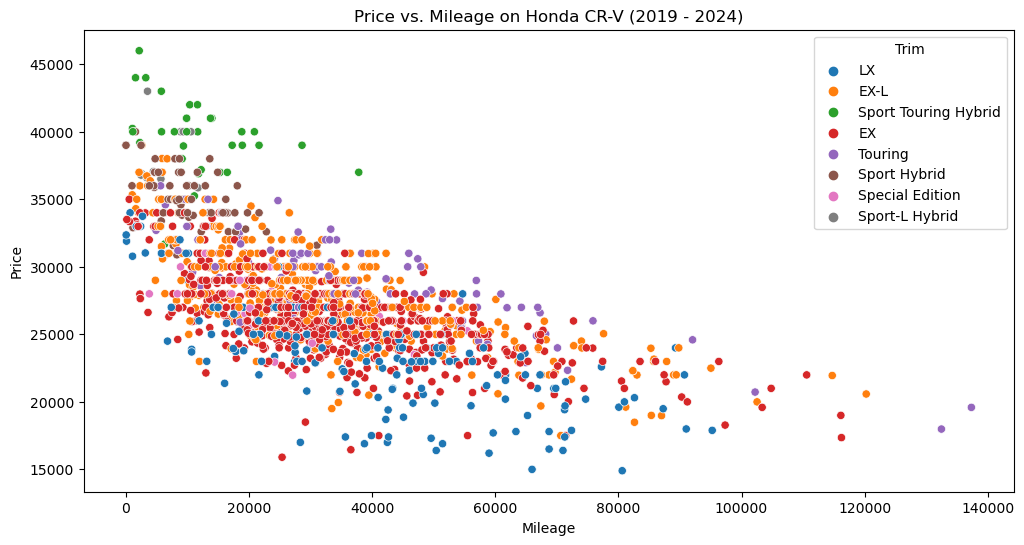

In [69]:
# Scatter plot for CR-V price vs mileage
crv_df = honda_df2[honda_df2['Model'] == 'CR-V']

sns.scatterplot(x='Mileage', y='Price', data=crv_df, hue='Trim')
plt.title("Price vs. Mileage on Honda CR-V (2019 - 2024)")
plt.savefig("honda_crv_scatterplot1.png")
plt.show()

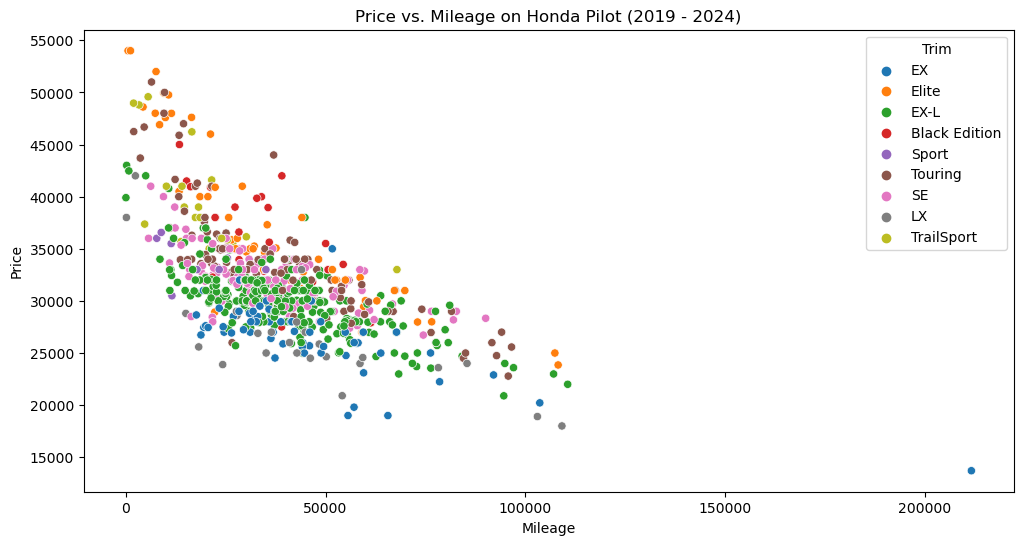

In [70]:
# Scatterplot of price vs mileage on Honda Pilot
pilot_df = honda_df2[honda_df2['Model'] == 'Pilot']

sns.scatterplot(x='Mileage', y='Price', data=pilot_df, hue='Trim')
plt.title('Price vs. Mileage on Honda Pilot (2019 - 2024)')

plt.savefig("honda_pilot_scatterplot1.png")
plt.show()

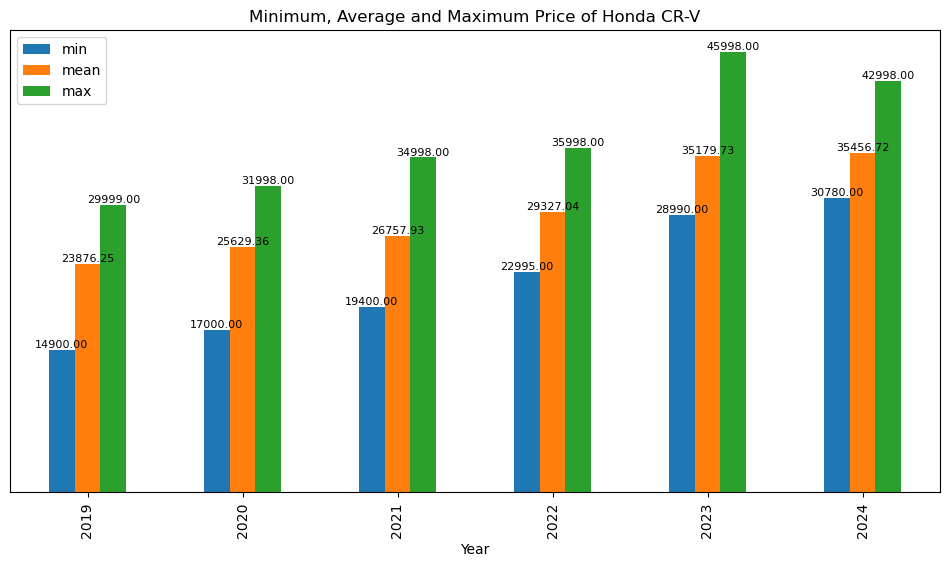

In [111]:
# Group by 'Year' and 'Trim' and aggregate 'Price' with 'min', 'mean', and 'max'
data = crv_df.groupby(['Year'])['Price'].aggregate(['min', 'mean', 'max'])

# Plot the average price
ax = data.plot(kind='bar')
plt.title('Minimum, Average and Maximum Price of Honda CR-V')

# Add data labels to the bar chart
for container in ax.containers:
    # Add data labels to each bar in the container
    for bar in container:
        height = bar.get_height()
        # Format the label to show the price with two decimal places
        label = f'{height:.2f}'
        # Set the text label slightly above the bar
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            label,
            ha='center',  # horizontal alignment
            va='bottom',  # vertical alignment
            fontsize=8,   # set the font size as desired
        )

ax.set_yticks([])

plt.savefig("honda_crv_mam.png")
plt.show()

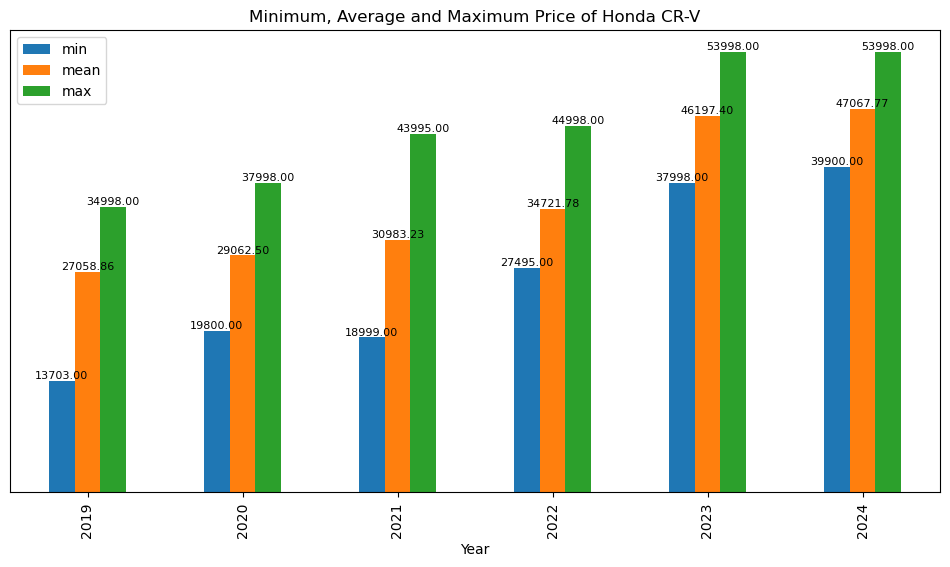

In [124]:
# Group by 'Year' and 'Trim' and aggregate 'Price' with 'min', 'mean', and 'max'
data = pilot_df.groupby(['Year'])['Price'].aggregate(['min', 'mean', 'max'])

# Plot the average price
ax = data.plot(kind='bar')
plt.title('Minimum, Average and Maximum Price of Honda CR-V')

# Add data labels to the bar chart
for container in ax.containers:
    # Add data labels to each bar in the container
    for bar in container:
        height = bar.get_height()
        # Format the label to show the price with two decimal places
        label = f'{height:.2f}'
        # Set the text label slightly above the bar
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            label,
            ha='center',  # horizontal alignment
            va='bottom',  # vertical alignment
            fontsize=8,   # set the font size as desired
        )

ax.set_yticks([])

plt.savefig("honda_pilot_mam.png")
plt.show()

In [137]:
# Create mileage threshold based on the average mileages driven in U.S
listings_count = listings_count.copy()

In [148]:
listings_count['Miles_threshold'] = (2024 - listings_count['Year']) * 15000

In [145]:
listings_count['Days_on_market'] = (pd.Timestamp.today() - pd.to_datetime(listings_count['Listed since'])).dt.days

In [171]:
# Filter flags
conditions = (
    (listings_count['Accidents'] == '0') &
    (listings_count['Owners'] == '1') &
    (listings_count['Usage'].isin(['Personal use only', 'Personal use'])) &
    (listings_count['Title Details'] == 'Clean Title') &
    (listings_count['Salvage Vehicle'] == 'No') &
    (listings_count['Frame Damage'] == 'No') &
    (listings_count['Theft History'] == 'No') &
    (listings_count['Lemon Status'] == 'No') &
    (listings_count['Mileage'] <= listings_count['Miles_threshold'])
)

toyota_filtered = listings_count[conditions]

In [173]:
toyota_filtered = toyota_filtered.reset_index(drop=True)
toyota_filtered = toyota_filtered.sort_values(by='price')


In [175]:
toyota_filtered.to_csv("toyota_filtered.csv", index=False)

In [177]:
honda_df['Miles_threshold'] = (2024 - honda_df['Year']) * 15000
honda_df['Days_on_market'] = (pd.Timestamp.today() - pd.to_datetime(honda_df['Listed since'])).dt.days

In [181]:
conditions = (
    (honda_df['Accidents'] == '0') &
    (honda_df['Owners'] == '1') &
    (honda_df['Usage'].isin(['Personal use only', 'Personal use'])) &
    (honda_df['Title Details'] == 'Clean Title') &
    (honda_df['Salvage Vehicle'] == 'No') &
    (honda_df['Frame Damage'] == 'No') &
    (honda_df['Theft History'] == 'No') &
    (honda_df['Lemon Status'] == 'No') &
    (honda_df['Mileage'] <= honda_df['Miles_threshold'])
)

honda_filtered = honda_df[conditions]

In [194]:
honda_filtered = honda_filtered.reset_index(drop=True)
honda_filtered = honda_filtered.sort_values(by='Price')
honda_filtered.to_csv("honda_filtered.csv", index=False)

In [195]:
toyota_filtered.rename(columns={'price': 'Price'}, inplace=True)

In [196]:
dummy1 = toyota_filtered[['Year', 'Make', 'Model', 'Trim', 'Price', 'Mileage', 'Miles_threshold', 'Listed since',
                         'car_url', 'Days_on_market']]

In [199]:
dummy2 = honda_filtered[['Year', 'Make', 'Model', 'Trim', 'Price', 'Mileage', 'Miles_threshold', 'Listed since',
                         'car_url', 'Days_on_market']]

In [201]:
dummy3 = pd.concat([dummy1, dummy2])

In [203]:
dummy3.to_csv('cars.csv', index=False)

In [3]:
cols_name = ['car_url', 'year_make_model', 'price_col', 'details_short', 'details_long' ]
mazda_df = pd.read_csv("/home/lfigil/Documents/car_scraper/car_dataset_original/mazda_suv.csv", names=cols_name)

In [4]:
mazda_df

,car_url,year_make_model,price_col,details_short,details_long
0,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,2021 Mazda CX-5\nGrand Touring Reserve 4dr SUV,"$21,815\ngreat price\n$3,384 below market","43,780 miles\nNo accidents, 1 Owner, Personal ...","['Located in Jamaica, NY / 18 miles away from ..."
1,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,2021 Mazda CX-5\nGrand Touring 4dr SUV,"$20,998\ngreat price\n$4,212 below market","32,963 miles\nNo accidents, 1 Owner, Personal ...","['Located in Jersey City, NJ / 13 miles away f..."
2,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,2021 Mazda CX-5\nTouring 4dr SUV,"$17,588\ngreat price\n$3,695 below market","54,762 miles\nNo accidents, 1 Owner, Rental ve...","['Located in Eastchester, NY / 13 miles away f..."
3,https://www.edmunds.com/mazda/cx-50/2024/vin/7...,Certified 2024 Mazda CX-50\n2.5 Turbo Premium ...,"$34,788\ngreat price\n$4,022 below market","6,445 miles\nNo accidents, 1 Owner, Personal u...","['Located in Wayne, NJ / 12 miles away from Ha..."
4,https://www.edmunds.com/mazda/cx-5/2020/vin/JM...,2020 Mazda CX-5\nGrand Touring 4dr SUV,"$16,995\ngreat price\n$3,816 below market","53,761 miles\nNo accidents, 1 Owner, Personal ...","['Located in Jamaica, NY / 18 miles away from ..."
...,...,...,...,...,...
990,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,Certified 2021 Mazda CX-5\nTouring 4dr SUV,Not Priced,"28,941 miles\nNo accidents, 1 Owner, Personal ...",NaN
991,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,2021 Mazda CX-5\nGrand Touring 4dr SUV,Not Priced,"57,229 miles\nNo accidents, 1 Owner, Rental ve...",NaN
992,https://www.edmunds.com/mazda/cx-5/2022/vin/JM...,2022 Mazda CX-5\n2.5 S Carbon Edition 4dr SUV,"$28,998","26,710 miles\nTitle issue reported, 1 Owner, P...",NaN
993,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,Certified 2021 Mazda CX-5\nTouring 4dr SUV,Not Priced,"40,442 miles\nNo accidents, 1 Owner, Personal ...",NaN


In [5]:
col1_tmp = mazda_df['year_make_model'].str.replace("\n", " ").str.strip().str.split(" ", expand=True)
col1_tmp = col1_tmp.rename(columns={0: 'Year', 1: 'Make', 2: 'Model', 3: 'Trim', 4: 'Doors', 5: 'type'})
col1_tmp = col1_tmp[col1_tmp['Year'] == 'Certified'].shift(-1, axis=1)

In [6]:
# Separate the `year_make_model` column by the newline which results in two new columns
tmp_cols_1 = mazda_df['year_make_model'].str.split("\n", expand=True)

# Replace rows with the word 'Certified' with and empty string
tmp_cols_1[0] = tmp_cols_1[0].str.replace('Certified', '').str.strip()

In [8]:
# Split into year, make, model columns to original df
mazda_df[['Year', 'Make', 'Model']] = tmp_cols_1[0] .str.split(" ", expand=True)

In [13]:
mazda_df['Trim'], mazda_df['Doors'], mazda_df['Type'] = zip(*tmp_cols_1[1].apply(extract_trim_info))
mazda_df['Price'] = mazda_df['price_col'].apply(extract_price)
# Separate the details_short column into new columns by new line for further information extraction
tmp_3 = mazda_df['details_short'].str.split("\n", expand=True)

# This new columns will need further cleaning
tmp_3 = tmp_3.rename(columns={0: 'mileage', 1: 'details1'})

In [16]:
mazda_df['Mileage'] = tmp_3['mileage'].apply(extract_miles)

In [18]:
tmp_4 = tmp_3['details1'].str.split(", ",expand=True)

In [23]:
tmp_4[['Owners', 'del']] = tmp_4[1].str.split(" ", expand=True)


In [25]:
tmp_4[['Accidents', 'del3', 'del4']] = tmp_4[0].str.split(" ", expand=True)
tmp_4['Accidents'] = tmp_4['Accidents'].replace("No", "0")
tmp_4 = tmp_4.rename(columns={2: "Usage"})
mazda_df[['Accidents', 'Owners', 'Usage']] = tmp_4[['Accidents', 'Owners', 'Usage']]

In [27]:
mazda_df.head(5)

,car_url,year_make_model,price_col,details_short,details_long,Year,Make,Model,Trim,Doors,Type,Price,Mileage,Accidents,Owners,Usage
0,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,2021 Mazda CX-5\nGrand Touring Reserve 4dr SUV,"$21,815\ngreat price\n$3,384 below market","43,780 miles\nNo accidents, 1 Owner, Personal ...","['Located in Jamaica, NY / 18 miles away from ...",2021,Mazda,CX-5,Grand Touring Reserve,4dr,SUV,21815.0,43780.0,0,1,Personal use only
1,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,2021 Mazda CX-5\nGrand Touring 4dr SUV,"$20,998\ngreat price\n$4,212 below market","32,963 miles\nNo accidents, 1 Owner, Personal ...","['Located in Jersey City, NJ / 13 miles away f...",2021,Mazda,CX-5,Grand Touring,4dr,SUV,20998.0,32963.0,0,1,Personal use
2,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,2021 Mazda CX-5\nTouring 4dr SUV,"$17,588\ngreat price\n$3,695 below market","54,762 miles\nNo accidents, 1 Owner, Rental ve...","['Located in Eastchester, NY / 13 miles away f...",2021,Mazda,CX-5,Touring,4dr,SUV,17588.0,54762.0,0,1,Rental vehicle
3,https://www.edmunds.com/mazda/cx-50/2024/vin/7...,Certified 2024 Mazda CX-50\n2.5 Turbo Premium ...,"$34,788\ngreat price\n$4,022 below market","6,445 miles\nNo accidents, 1 Owner, Personal u...","['Located in Wayne, NJ / 12 miles away from Ha...",2024,Mazda,CX-50,2.5 Turbo Premium,4dr,SUV,34788.0,6445.0,0,1,Personal use
4,https://www.edmunds.com/mazda/cx-5/2020/vin/JM...,2020 Mazda CX-5\nGrand Touring 4dr SUV,"$16,995\ngreat price\n$3,816 below market","53,761 miles\nNo accidents, 1 Owner, Personal ...","['Located in Jamaica, NY / 18 miles away from ...",2020,Mazda,CX-5,Grand Touring,4dr,SUV,16995.0,53761.0,0,1,Personal use only


In [29]:
tmp_details_long = mazda_df['details_long'].str.split(",", expand=True)
# Define the key phrases you want to extract
keys_to_extract = {
    'Title Details': 'Title Details:',
    'Salvage Vehicle': 'Salvage Vehicle:',
    'Frame Damage': 'Frame Damage:',
    'Theft History': 'Theft History:',
    'Lemon Status': 'Lemon Status:',
    'Certified Pre-Owned': 'Certified Pre-Owned:',
    'Listed since': 'Listed since'
}

# Initialize empty columns for the keys
for key in keys_to_extract:
    mazda_df[key] = None

In [36]:
tmp_details_long.fillna("", inplace=True)

In [37]:
# Function to extract values based on the specified keys
def extract_information(details_list, keys):
    # Create a dictionary to hold the extracted values
    extracted_info = {}
    
    # Iterate through each string in the list
    for detail in details_list:
        # Check each key to see if it is present in the current detail string
        for key, prefix in keys.items():
            if prefix in detail:
                # Extract the value after the key prefix
                value = detail.split(prefix)[1].strip()
                # Store the value in the dictionary
                extracted_info[key] = value
    
    return extracted_info

In [39]:
for index, row in mazda_df.iterrows():
    # Parse the list of strings from the 'details_long' column
    details_list = eval(row['details_long'])  # Convert string representation of list to actual list
    
    # Extract the information using the function
    extracted_info = extract_information(details_list, keys_to_extract)
    
    # Assign the extracted information to the appropriate columns
    for key, value in extracted_info.items():
        mazda_df.loc[index, key] = value


TypeError: eval() arg 1 must be a string, bytes or code object

In [ ]:

honda_crv_df['Certified Pre-Owned'] = honda_crv_df['Certified Pre-Owned'].str.split("\n")[0]
honda_crv_df['Certified Pre-Owned'] = honda_crv_df['Certified Pre-Owned'].str.split("\n",expand=True)[0]
honda_crv_df['Listed since'] = pd.to_datetime(honda_crv_df['Listed since'].str.replace(": ", "").str.strip())

In [41]:
mazda_df

,car_url,year_make_model,price_col,details_short,details_long,Year,Make,Model,Trim,Doors,...,Accidents,Owners,Usage,Title Details,Salvage Vehicle,Frame Damage,Theft History,Lemon Status,Certified Pre-Owned,Listed since
0,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,2021 Mazda CX-5\nGrand Touring Reserve 4dr SUV,"$21,815\ngreat price\n$3,384 below market","43,780 miles\nNo accidents, 1 Owner, Personal ...","['Located in Jamaica, NY / 18 miles away from ...",2021,Mazda,CX-5,Grand Touring Reserve,4dr,...,0,1,Personal use only,Clean Title,No,No,No,No,No\nListed since: 02-23-2024,: 02-23-2024
1,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,2021 Mazda CX-5\nGrand Touring 4dr SUV,"$20,998\ngreat price\n$4,212 below market","32,963 miles\nNo accidents, 1 Owner, Personal ...","['Located in Jersey City, NJ / 13 miles away f...",2021,Mazda,CX-5,Grand Touring,4dr,...,0,1,Personal use,Clean Title,No,No,No,No,No\nListed since: 02-08-2024,: 02-08-2024
2,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,2021 Mazda CX-5\nTouring 4dr SUV,"$17,588\ngreat price\n$3,695 below market","54,762 miles\nNo accidents, 1 Owner, Rental ve...","['Located in Eastchester, NY / 13 miles away f...",2021,Mazda,CX-5,Touring,4dr,...,0,1,Rental vehicle,Clean Title,No,No,No,No,No\nListed since: 03-06-2024,: 03-06-2024
3,https://www.edmunds.com/mazda/cx-50/2024/vin/7...,Certified 2024 Mazda CX-50\n2.5 Turbo Premium ...,"$34,788\ngreat price\n$4,022 below market","6,445 miles\nNo accidents, 1 Owner, Personal u...","['Located in Wayne, NJ / 12 miles away from Ha...",2024,Mazda,CX-50,2.5 Turbo Premium,4dr,...,0,1,Personal use,Clean Title,No,No,No,No,Yes\nListed since: 04-11-2024,: 04-11-2024
4,https://www.edmunds.com/mazda/cx-5/2020/vin/JM...,2020 Mazda CX-5\nGrand Touring 4dr SUV,"$16,995\ngreat price\n$3,816 below market","53,761 miles\nNo accidents, 1 Owner, Personal ...","['Located in Jamaica, NY / 18 miles away from ...",2020,Mazda,CX-5,Grand Touring,4dr,...,0,1,Personal use only,Clean Title,No,No,No,No,No\nListed since: 04-11-2024,: 04-11-2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,Certified 2021 Mazda CX-5\nTouring 4dr SUV,Not Priced,"28,941 miles\nNo accidents, 1 Owner, Personal ...",NaN,2021,Mazda,CX-5,Touring,4dr,...,0,1,Personal use,None,None,None,None,None,None,None
991,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,2021 Mazda CX-5\nGrand Touring 4dr SUV,Not Priced,"57,229 miles\nNo accidents, 1 Owner, Rental ve...",NaN,2021,Mazda,CX-5,Grand Touring,4dr,...,0,1,Rental vehicle,None,None,None,None,None,None,None
992,https://www.edmunds.com/mazda/cx-5/2022/vin/JM...,2022 Mazda CX-5\n2.5 S Carbon Edition 4dr SUV,"$28,998","26,710 miles\nTitle issue reported, 1 Owner, P...",NaN,2022,Mazda,CX-5,2.5 S Carbon Edition,4dr,...,Title,1,Personal use only,None,None,None,None,None,None,None
993,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...,Certified 2021 Mazda CX-5\nTouring 4dr SUV,Not Priced,"40,442 miles\nNo accidents, 1 Owner, Personal ...",NaN,2021,Mazda,CX-5,Touring,4dr,...,0,1,Personal use,None,None,None,None,None,None,None


In [42]:
mazda_df['Certified Pre-Owned'] = mazda_df['Certified Pre-Owned'].str.split("\n",expand=True)[0]
mazda_df['Listed since'] = pd.to_datetime(mazda_df['Listed since'].str.replace(": ", "").str.strip())

In [48]:
# Get only the clean data into new df
mazda_df_clean = mazda_df[['Year', 'Make', 'Model', 'Trim', 'Type', 'Price', 'Mileage', 
                           'Accidents', 'Owners', 'Usage', 'car_url']]

save_path = "/home/lfigil/Documents/car_scraper/car_dataset_original/mazda_df_clean.csv"

mazda_df_clean.to_csv(save_path, index=False)

print(f"file save at {save_path}...")

file save at /home/lfigil/Documents/car_scraper/car_dataset_original/mazda_df_clean.csv...


In [49]:
mazda_clean_df = pd.read_csv("/home/lfigil/Documents/car_scraper/car_dataset_original/mazda_df_clean.csv")
mazda_clean_df

,Year,Make,Model,Trim,Type,Price,Mileage,Accidents,Owners,Usage,car_url
0,2021,Mazda,CX-5,Grand Touring Reserve,SUV,21815.0,43780.0,0,1,Personal use only,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...
1,2021,Mazda,CX-5,Grand Touring,SUV,20998.0,32963.0,0,1,Personal use,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...
2,2021,Mazda,CX-5,Touring,SUV,17588.0,54762.0,0,1,Rental vehicle,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...
3,2024,Mazda,CX-50,2.5 Turbo Premium,SUV,34788.0,6445.0,0,1,Personal use,https://www.edmunds.com/mazda/cx-50/2024/vin/7...
4,2020,Mazda,CX-5,Grand Touring,SUV,16995.0,53761.0,0,1,Personal use only,https://www.edmunds.com/mazda/cx-5/2020/vin/JM...
...,...,...,...,...,...,...,...,...,...,...,...
990,2021,Mazda,CX-5,Touring,SUV,NaN,28941.0,0,1,Personal use,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...
991,2021,Mazda,CX-5,Grand Touring,SUV,NaN,57229.0,0,1,Rental vehicle,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...
992,2022,Mazda,CX-5,2.5 S Carbon Edition,SUV,28998.0,26710.0,Title,1,Personal use only,https://www.edmunds.com/mazda/cx-5/2022/vin/JM...
993,2021,Mazda,CX-5,Touring,SUV,NaN,40442.0,0,1,Personal use,https://www.edmunds.com/mazda/cx-5/2021/vin/JM...


In [50]:
mazda_clean_df.isna().sum()

Year          0
Make          0
Model         0
Trim          0
Type          0
Price        65
Mileage       6
Accidents     0
Owners        0
Usage         0
car_url       0
dtype: int64

In [62]:
mazda_clean_df = mazda_clean_df.dropna(subset=['Price', 'Mileage'])

In [70]:
mazda_clean_df.isna().sum()

Year         0
Make         0
Model        0
Trim         0
Type         0
Price        0
Mileage      0
Accidents    0
Owners       0
Usage        0
car_url      0
dtype: int64

<Axes: xlabel='Mileage', ylabel='Price'>

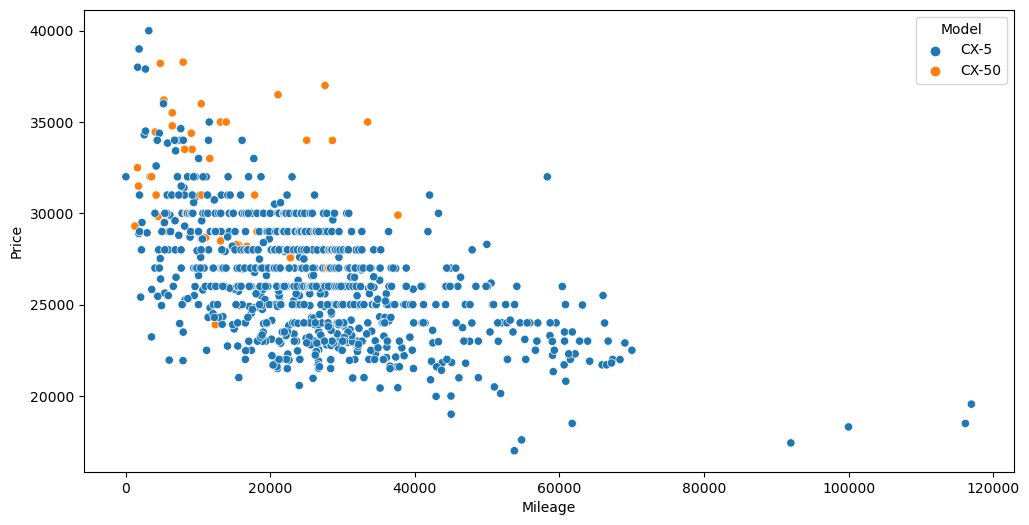

In [72]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=mazda_clean_df, x='Mileage', y='Price', hue='Model')

In [75]:
mazda_clean_df[['Price', 'Mileage']].describe()

,Price,Mileage
count,925.000000,925.000000
mean,26369.320000,25722.432432
std,3529.956872,14864.205236
min,16995.000000,30.000000
25%,23900.000000,16102.000000
50%,25998.000000,24287.000000
75%,28299.000000,32041.000000
max,39998.000000,116979.000000


In [77]:
mazda_clean_df['Miles_threshold'] = (2024 - mazda_clean_df['Year']) * 15000

In [80]:
mazda_filtered = mazda_clean_df[(mazda_clean_df['Mileage'] <= mazda_clean_df['Miles_threshold'])]

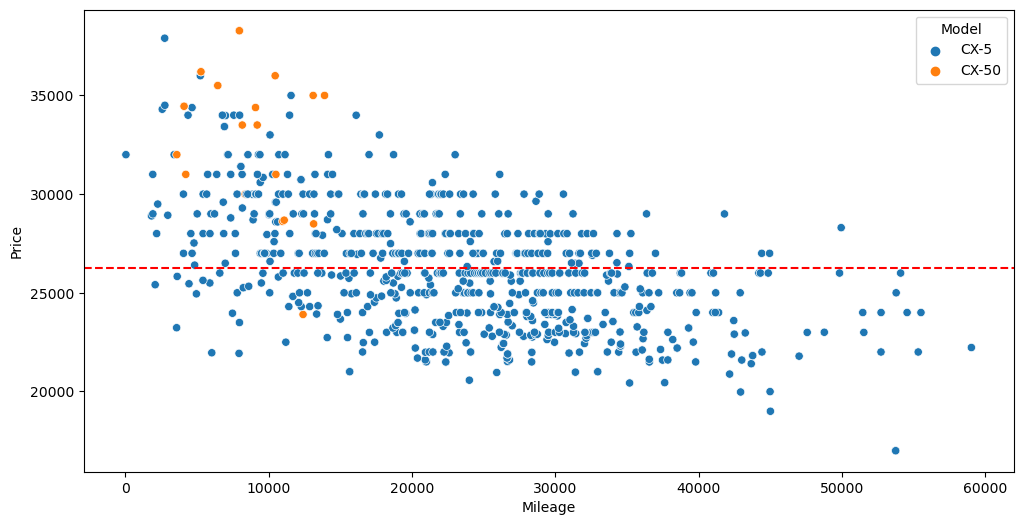

In [88]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=mazda_filtered.sort_values(by=['Price', 'Mileage']), x='Mileage', y='Price', hue='Model')
plt.axhline(y=mazda_filtered['Price'].mean(), color='r', linestyle='--')
plt.show()

In [90]:
mazda_listings = mazda_filtered[mazda_filtered['Price'] <= mazda_filtered['Price'].mean()]
mazda_listings.to_csv("mazda_listings.csv", index=False)